In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!git clone https://github.com/Eoli-an/influence-release customCNN
  

Cloning into 'customCNN'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 620 (delta 172), reused 61 (delta 11), pack-reused 398
Receiving objects: 100% (620/620), 113.98 MiB | 30.50 MiB/s, done.
Resolving deltas: 100% (448/448), done.
Checking out files: 100% (57/57), done.


In [0]:
import os
os.chdir('./customCNN')

In [23]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/Eoli-an/influence-release
   b20569e..60a3b07  master     -> origin/master
Updating b20569e..60a3b07
Fast-forward
 scripts/load_mnist.py | 1 +
 1 file changed, 1 insertion(+)


# Training CNN and saving the influence of every training example(for the test image with test_idx)

handling imports

In [4]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import IPython

import math
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)

import tensorflow as tf

from influence.all_CNN_c import All_CNN_C
from scripts.load_mnist import load_small_mnist, load_mnist


Using TensorFlow backend.


loading the dataset

In [0]:
import h5py
path_to_matrices = "data/default_labeled_balanced.hdf5"
dataset = h5py.File(path_to_matrices, 'r')

In [0]:
matrices = np.array(dataset['dense_matrices'])
labels = np.array(dataset['label_vectors'])

In [0]:
randomize = np.arange(len(matrices))
np.random.shuffle(randomize)
matrices = matrices[randomize]
labels = labels[randomize]

In [0]:
#from one hot to integer coding
i = 0
new_labels = []
for label in labels:
  index = np.argmax(label)
  new_labels.append(index)
  i+=1

labels = new_labels
labels = np.asarray(labels)

In [0]:
training_test_split = 0.8
index = int(training_test_split * len(matrices))

train_matrices = np.expand_dims(matrices[:index], axis=3)
train_labels = labels[:index]

validation_matrices = np.expand_dims(matrices[index + 1:], axis=3)
validation_labels = labels[index + 1:]

In [0]:
from tensorflow.contrib.learn.python.learn.datasets import base
from influence.dataset import DataSet


In [0]:
train = DataSet(train_matrices, train_labels)
validation = DataSet(validation_matrices, validation_labels)
test = DataSet(validation_matrices, validation_labels)

data_sets = base.Datasets(train=train, validation=validation, test=test)

In [12]:
data_sets2 = load_small_mnist('data')  

ok
('Extracting', u'data/train-images-idx3-ubyte.gz')
('Extracting', u'data/train-labels-idx1-ubyte.gz')
('Extracting', u'data/t10k-images-idx3-ubyte.gz')
('Extracting', u'data/t10k-labels-idx1-ubyte.gz')
(59500,)


In [21]:
print(data_sets.train.labels.shape)
#print(data_sets2.train.labels.shape)
print(data_sets.train.x.shape)
#print(data_sets2.train.x.shape)

(484,)
(484, 16384)


defining the CNN

training the CNN

In [22]:
num_classes = 4
input_side = 128
input_channels = 1
input_dim = input_side * input_side * input_channels 
weight_decay = 0.001
batch_size = 50

initial_learning_rate = 0.0001 
decay_epochs = [10000, 20000]
hidden1_units = 8
hidden2_units = 8
hidden3_units = 8
conv_patch_size = 3
keep_probs = [1.0, 1.0]


model = All_CNN_C(
    input_side=input_side, 
    input_channels=input_channels,
    conv_patch_size=conv_patch_size,
    hidden1_units=hidden1_units, 
    hidden2_units=hidden2_units,
    hidden3_units=hidden3_units,
    weight_decay=weight_decay,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    damping=1e-2,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output', 
    log_dir='log',
    model_name='mnist_small_all_cnn_c')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
num_steps = 5000
model.train(
    num_steps=num_steps, 
    iter_to_switch_to_batch=10000,
    iter_to_switch_to_sgd=10000)
iter_to_load = num_steps - 1


Training for 5000 steps
Step 0: loss = 2496810496.00000000 (2.900 sec)
Step 1000: loss = 5504.71240234 (0.073 sec)
Step 2000: loss = 2858.06127930 (0.072 sec)
Step 3000: loss = 5210.56542969 (0.073 sec)
Step 4000: loss = 33484.22265625 (0.073 sec)
Train loss (w reg) on all data: 1686422.1
Train loss (w/o reg) on all data: 1686422.1
Test loss (w/o reg) on all data: 987032.94
Train acc on all data:  0.7107438016528925
Test acc on all data:   0.425
Norm of the mean of gradients: 60217984.0
Norm of the params: 188.62766


calculating the influence

In [24]:
test_idx = 50

CNN_predicted_loss_diffs = model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(model.data_sets.train.labels)),
    force_refresh=True)

Norm of test gradient: 729.28955
Function value: -324261942624.8125
Split function value: -324261412864.0, -529760.8
Predicted loss diff on train_idx 50: 0.0
Function value: -3125439112177.5
Split function value: -3125438578688.0, -533489.5
Predicted loss diff on train_idx 50: 0.0
Function value: -1.0545257967262898e+18
Split function value: -1.0545257967203123e+18, -5977413.5
Predicted loss diff on train_idx 50: 0.0
Function value: -2.828248746245584e+18
Split function value: -2.828248746238673e+18, -6910767.0
Predicted loss diff on train_idx 50: 0.0
Function value: -1.0717206665766371e+24
Split function value: -1.0717206665766344e+24, -2735750000.0
Predicted loss diff on train_idx 50: 0.0
Function value: -1.0717206665766371e+24
Split function value: -1.0717206665766344e+24, -2735750000.0
Predicted loss diff on train_idx 50: 0.0
Optimization terminated successfully.
         Current function value: -1071720666576637124411392.000000
         Iterations: 6
         Function evaluations:

saving the influence

In [0]:
np.savez(
    'output/CNN_results', 
    test_idx=test_idx,
    CNN_predicted_loss_diffs=CNN_predicted_loss_diffs
    
)

# **Loading influences and plotting the most influential pictures**

getting Xtrain of the Training Dataset

In [0]:
X_train = data_sets.train.x

loading the influences

In [0]:
f = np.load('output/CNN_results.npz')
    
test_idx = f['test_idx']
CNN_predicted_loss_diffs = f['CNN_predicted_loss_diffs']


Test Image:
Top 5 most influenatial matrices


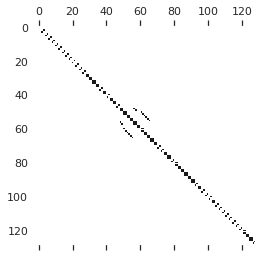

In [35]:
print("Test Image:")
plt.spy(np.reshape(X_train[test_idx, :], [128, 128]))
print("Top 5 most influenatial matrices")

In [0]:
x_train = []
for counter, train_idx in enumerate(np.argsort(CNN_predicted_loss_diffs)[-5:]):
    x_train.append(X_train[train_idx, :])
    
    

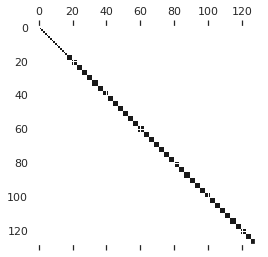

In [44]:
plt.spy(np.reshape(x_train[0], [128, 128]))

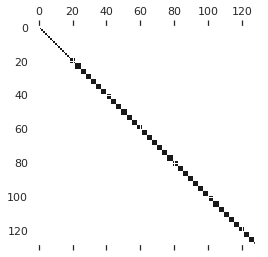

In [49]:
plt.spy(np.reshape(x_train[1], [128, 128]))

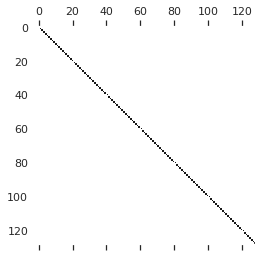

In [50]:
plt.spy(np.reshape(x_train[2], [128, 128]))

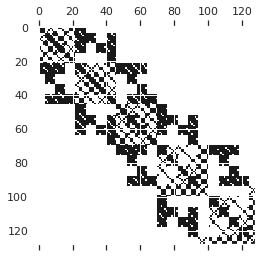

In [51]:
plt.spy(np.reshape(x_train[3], [128, 128]))

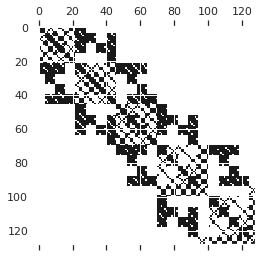

In [52]:
plt.spy(np.reshape(x_train[4], [128, 128]))